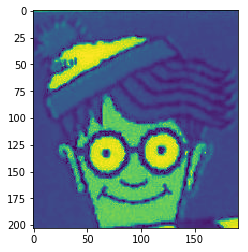

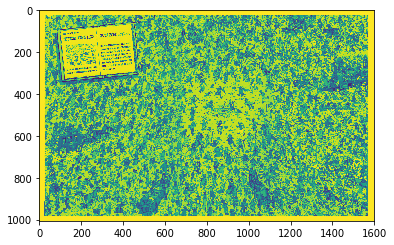

500
--
(455.0640869140625, 286.654541015625)
(335.9232482910156, 122.34241485595703)
(406.0, 157.0)
(315.187255859375, 114.04801940917969)
(141.0, 114.0)
(322.0, 171.0)
(216.0, 295.0)
(317.2608337402344, 124.416015625)
(148.0, 109.0)
(569.825439453125, 729.0779418945312)
(205.0, 290.0)
(953.8561401367188, 588.9024658203125)
(423.0, 204.0)
(320.0, 230.0)
(730.9691162109375, 361.9013671875)
(321.0, 236.0)
(128.16000366210938, 144.0)
(134.40000915527344, 286.8000183105469)
(123.60000610351562, 144.0)


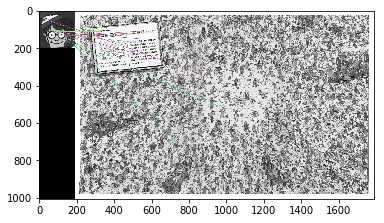

(<matplotlib.image.AxesImage at 0x7faf007e9be0>, None)

In [1]:
"""
Running ORB detector/descriptor
SURF can be run by using cv2.xfeatures2d.SURF_create(), but ORB does better, so i only included that.
"""

import numpy as np
import cv2
from matplotlib import pyplot as plt
import cyvlfeat as vlfeat

img1 = cv2.imread('templates/waldo/032/0.jpg',0)
plt.imshow(img1),plt.show()

img2 = cv2.imread('datasets/JPEGImages/003.jpg',0)
plt.imshow(img2),plt.show()

orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(des1,des2)

matches.sort(key=lambda x: x.distance, reverse=False)

matches = matches[:int(len(matches)*0.1)]

print(len(kp2))
print("--")

for match in matches:
    print(kp2[match.trainIdx].pt)
    
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None, flags=2)
    
# you'll have to zoom in a lot to see the matched keypoints
plt.imshow(img3),plt.show()

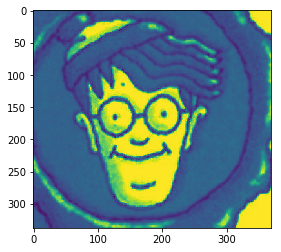

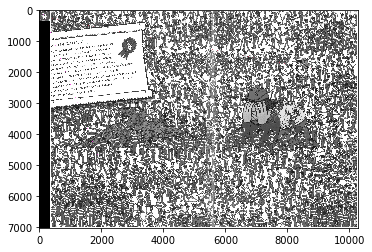

(<matplotlib.image.AxesImage at 0x7faf0073b9b0>, None)

In [2]:
"""
I was just testing out different approaches to detect, match and draw the matches.
This is a mixture of many different solutions on the internet and is very convoluted. 
It can be ignored for now.
"""

import numpy as np
import cv2
from matplotlib import pyplot as plt

def filter_matches(kp1, kp2, matches, ratio = 0.75):
    mkp1, mkp2 = [], []
    filtered = []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            m = m[0]
            mkp1.append( kp1[m.queryIdx] )
            mkp2.append( kp2[m.trainIdx] )
            filtered.append(m)
#     kp_pairs = zip(mkp1, mkp2)
    return (mkp1,mkp2,filtered)


def explore_match(win, img1, img2, kp_pairs, status = None, H = None):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    vis = numpy.zeros((max(h1, h2), w1+w2), numpy.uint8)
    vis[:h1, :w1] = img1
    vis[:h2, w1:w1+w2] = img2
    vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

    if H is not None:
        corners = numpy.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]])
        corners = numpy.int32( cv2.perspectiveTransform(corners.reshape(1, -1, 2), H).reshape(-1, 2) + (w1, 0) )
        cv2.polylines(vis, [corners], True, (255, 255, 255))

    if status is None:
        status = numpy.ones(len(kp_pairs), numpy.bool_)
    p1 = numpy.int32([kpp[0].pt for kpp in kp_pairs])
    p2 = numpy.int32([kpp[1].pt for kpp in kp_pairs]) + (w1, 0)

    green = (0, 255, 0)
    red = (0, 0, 255)
    white = (255, 255, 255)
    kp_color = (51, 103, 236)
    for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
        if inlier:
            col = green
            cv2.circle(vis, (x1, y1), 2, col, -1)
            cv2.circle(vis, (x2, y2), 2, col, -1)
        else:
            col = red
            r = 2
            thickness = 3
            cv2.line(vis, (x1-r, y1-r), (x1+r, y1+r), col, thickness)
            cv2.line(vis, (x1-r, y1+r), (x1+r, y1-r), col, thickness)
            cv2.line(vis, (x2-r, y2-r), (x2+r, y2+r), col, thickness)
            cv2.line(vis, (x2-r, y2+r), (x2+r, y2-r), col, thickness)
    vis0 = vis.copy()
    for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
        if inlier:
            cv2.line(vis, (x1, y1), (x2, y2), green)
    cv2.imshow(win, vis)   
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def draw_matches(window_name, kp_pairs, img1, img2):
    """Draws the matches for """
    mkp1, mkp2 = zip(*kp_pairs)

    p1 = numpy.float32([kp.pt for kp in mkp1])
    p2 = numpy.float32([kp.pt for kp in mkp2])

    if len(kp_pairs) >= 4:
        H, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)
    else:
        H, status = None, None
    if len(p1):
        explore_match(window_name, img1, img2, kp_pairs, status, H)

img1 = cv2.imread('templates/waldo/001/0.jpg',0)
plt.imshow(img1),plt.show()

img2 = cv2.imread('datasets/JPEGImages/001.jpg',0)
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

matcher = cv2.BFMatcher(cv2.NORM_L2)

matches = matcher.knnMatch(des1, des2, k=2) 

good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
                
# M, mask = cv2.findHomography(np.asarray(kp1), np.asarray(kp2), cv2.RANSAC, 5.0)


img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,flags=2)

# if kp_pairs:
#     draw_matches('Matching Features', kp_pairs, img1, img2)    
# else:
#     print("No matches found")

# kp1_sorted = sorted(kp1, key = lambda x:x.pt[0])

# for kp in kp1_sorted:
#     print(kp.pt)

# # create BFMatcher object
# bf = cv2.BFMatcher()

# # Match descriptors.
# matches = bf.knnMatch(des1,des2, k=2)

# # Apply ratio test
# good = []
# for m,n in matches:
#     if m.distance < 0.7*n.distance:
#         good.append(m)

# src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
# dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
# matchesMask = mask.ravel().tolist()

# h,w = img1.shape
# pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
# dst = cv2.perspectiveTransform(pts,M)

# img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# # Sort them in the order of their distance.
# matches = sorted(matches, key = lambda x:x.distance)

# for i,match in enumerate(matches):
#     if i==10:
#         break
#     print(f"{kp2[match.trainIdx].pt}, {match.distance}")

    
# draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                    singlePointColor = None,
#                    matchesMask = matchesMask, # draw only inliers
#                    flags = 2)

# img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import cyvlfeat as vlfeat
from sklearn.svm import LinearSVC, SVC
import os.path as osp
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread
import pickle
from random import shuffle
from scipy.spatial.distance import cdist

In [4]:
def bags_of_sifts(image_paths=[], vocab_filename='', img=None):

    with open(vocab_filename, 'rb') as f:
        vocab = pickle.load(f)

    vocab_size = vocab.shape[0]
    print(vocab_size)
    feats = []
    
    if len(image_paths) == 0:
        image_paths = ['']
    
    for path in image_paths:
        image = np.asarray(plt.imread(path)) if path != '' else img
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        (frames, descriptors) = vlfeat.sift.dsift(img_gray, fast=True, step=10)
        
        samples = descriptors
        
        histogram = np.zeros(vocab_size)
        D = cdist(samples, vocab)
        
        closet_words = np.argmin(D, axis=1)

#         for i in range(D.shape[0]):
#             min_index = np.argmin(D[i])
#             histogram[min_index]+=1

        histogram, bin_edges = np.histogram(closet_words, bins=np.arange(0, vocab_size+1))

        if np.linalg.norm(histogram) == 0.0:
            print(descriptors.shape)
            print(D.shape)
            print(np.linalg.norm(histogram))
            print(img_gray.shape)
            print("--")
            
            
        histogram = histogram / np.linalg.norm(histogram)
        feats.append(histogram)
        
    N = len(image_paths)
    d = vocab_size
    feats = np.asarray(feats)
    feats = feats.reshape((N,d))
    return feats


def build_vocabulary(image_paths, vocab_size):
    dim = 128     
    vocab = np.zeros((vocab_size,dim))
    sift_features = []

    for path in image_paths:
        image = np.asarray(plt.imread(path))
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        (frames, descriptors) = vlfeat.sift.dsift(img_gray, fast=True, step=5)

        samples = np.random.permutation(descriptors)[:20]

        for descriptor in samples:
            sift_features.append(descriptor)

    sift_features = np.asarray(sift_features).astype('float64').reshape((-1,128))
    vocab = vlfeat.kmeans.kmeans(sift_features, vocab_size)

    return vocab


def svm_classify(train_image_feats, train_labels, test_image_feats):
    categories = list(set(train_labels))
    test_labels = []
    
    clf = LinearSVC(C=2)
    clf.fit(train_image_feats, train_labels)
    test_labels = clf.predict(test_image_feats)

    return test_labels


def test_accuracy(test_labels, predicted_labels):
    num_correct = 0
    for i,label in enumerate(test_labels):
        if (predicted_labels[i] == label):
            num_correct += 1
    return num_correct/len(test_labels)

In [5]:
waldo_paths = []
wenda_paths = []
wizard_paths = []
all_paths = []

test_image_paths = []
with open('datasets/ImageSets/val.txt') as file:
    for img_id in file.readlines():
        img_id = img_id.rstrip()
        test_image_paths.append('datasets/JPEGImages/{}.jpg'.format(img_id))

file.close()


template_dirs = ["templates/waldo","templates/wenda","templates/wizard"]

for i in range(len(template_dirs)):
    for img_id in os.listdir(template_dirs[i]):
        path_to_dir = os.path.join(template_dirs[i], '{}'.format(img_id)).rstrip()
        if not os.path.isdir(path_to_dir):
            continue
        list_of_files = os.listdir(path_to_dir)
        for file_name in list_of_files:
            all_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())
            if i==0:
                waldo_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())
            if i==1:
                wenda_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())
            if i==2:
                wizard_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())

print(sorted(all_paths))
print(len(waldo_paths))
print(len(wenda_paths))
print(len(wizard_paths))

['templates/waldo/000/0.jpg', 'templates/waldo/001/0.jpg', 'templates/waldo/001/1.jpg', 'templates/waldo/002/0.jpg', 'templates/waldo/004/0.jpg', 'templates/waldo/004/1.jpg', 'templates/waldo/004/2.jpg', 'templates/waldo/004/3.jpg', 'templates/waldo/004/4.jpg', 'templates/waldo/004/5.jpg', 'templates/waldo/004/6.jpg', 'templates/waldo/005/0.jpg', 'templates/waldo/006/0.jpg', 'templates/waldo/007/0.jpg', 'templates/waldo/007/1.jpg', 'templates/waldo/008/0.jpg', 'templates/waldo/009/0.jpg', 'templates/waldo/009/1.jpg', 'templates/waldo/010/0.jpg', 'templates/waldo/010/1.jpg', 'templates/waldo/011/0.jpg', 'templates/waldo/012/0.jpg', 'templates/waldo/013/0.jpg', 'templates/waldo/014/0.jpg', 'templates/waldo/015/0.jpg', 'templates/waldo/016/0.jpg', 'templates/waldo/016/1.jpg', 'templates/waldo/017/0.jpg', 'templates/waldo/017/1.jpg', 'templates/waldo/017/2.jpg', 'templates/waldo/019/0.jpg', 'templates/waldo/019/1.jpg', 'templates/waldo/020/0.jpg', 'templates/waldo/020/1.jpg', 'templates/wa

In [6]:
# get vocab
print('Using the BAG-OF-SIFT representation for images')

vocab_filename = 'vocab.pkl'

# print('No existing visual word vocabulary found. Computing one from training images')
vocab_size = 200  # Larger values will work better (to a point) but be slower to compute
vocab = build_vocabulary(all_paths,vocab_size)
print(np.isnan(vocab).any())
    
with open(vocab_filename, 'wb') as f:
    pickle.dump(vocab, f)

    print('{:s} saved'.format(vocab_filename))

Using the BAG-OF-SIFT representation for images
False
vocab.pkl saved


In [7]:
#get bags of sifts
template_percentage = 0.6

print(f"all_feats = {len(all_paths)}")

# waldo_feats = bags_of_sifts(waldo_paths,vocab_filename)
# wenda_feats = bags_of_sifts(wenda_paths,vocab_filename)
# wizard_feats = bags_of_sifts(wizard_paths,vocab_filename)

# print(np.isnan(waldo_feats).any())
# print(np.isnan(wenda_feats).any())
# print(np.isnan(wizard_feats).any())

# print(waldo_feats)
# print(wenda_feats)
# print(wizard_feats)


waldo_feats = bags_of_sifts(waldo_paths[:int(len(waldo_paths)*template_percentage)],vocab_filename)
wenda_feats = bags_of_sifts(wenda_paths[:int(len(wenda_paths)*template_percentage)],vocab_filename)
wizard_feats = bags_of_sifts(wizard_paths[:int(len(wizard_paths)*template_percentage)],vocab_filename)

training_feats = []
training_feats.extend(waldo_feats)
training_feats.extend(wenda_feats)
training_feats.extend(wizard_feats)

print(len(waldo_feats))
print(len(wenda_feats))
print(len(wizard_feats))
print("--\ntest_feats_lengths")

# test_image_feats 
waldo_test_feats = bags_of_sifts(waldo_paths[int(len(waldo_paths)*template_percentage):len(waldo_paths)],vocab_filename)
wenda_test_feats = bags_of_sifts(wenda_paths[int(len(wenda_paths)*template_percentage):len(wenda_paths)],vocab_filename)
wizard_test_feats = bags_of_sifts(wizard_paths[int(len(wizard_paths)*template_percentage):len(wizard_paths)],vocab_filename)

test_feats = []
test_feats.extend(waldo_test_feats)
test_feats.extend(wenda_test_feats)
test_feats.extend(wizard_test_feats)

#set training labels
train_labels = []
train_labels.extend(["waldo"]*len(waldo_feats))
train_labels.extend(["wenda"]*len(wenda_feats))
train_labels.extend(["wizard"]*len(wizard_feats))

print(len(waldo_test_feats))
print(len(wenda_test_feats))
print(len(wizard_test_feats))
print("--\ntest_labels lengths")

ground_truth_test_labels = []
ground_truth_test_labels.extend(["waldo"]*len(waldo_test_feats))
ground_truth_test_labels.extend(["wenda"]*len(wenda_test_feats))
ground_truth_test_labels.extend(["wizard"]*len(wizard_test_feats))

print(len(ground_truth_test_labels))

print(len(train_labels))
print(len(training_feats))
print("--")

print("done")

all_feats = 184
200
200
200
74
21
14
--
test_feats_lengths
200
200
200
50
15
10
--
test_labels lengths
75
109
109
--
done


In [8]:
predicted_labels = svm_classify(training_feats, train_labels, test_feats)

In [9]:
print(test_accuracy(ground_truth_test_labels, predicted_labels))

print(predicted_labels)

0.6933333333333334
['waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo'
 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo'
 'waldo' 'waldo' 'waldo' 'wenda' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo'
 'waldo' 'wenda' 'waldo' 'waldo' 'waldo' 'waldo' 'wenda' 'wizard' 'waldo'
 'waldo' 'waldo' 'waldo' 'wizard' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo'
 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'wenda' 'waldo'
 'waldo' 'waldo' 'wenda' 'waldo' 'waldo' 'waldo' 'wenda' 'waldo' 'waldo'
 'waldo' 'waldo' 'wizard' 'wizard' 'waldo' 'waldo' 'waldo' 'wizard' 'waldo'
 'waldo' 'wenda' 'wizard']


200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


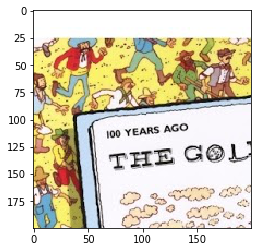

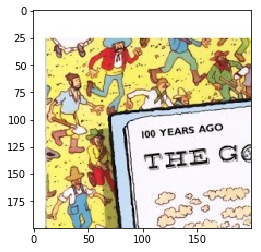

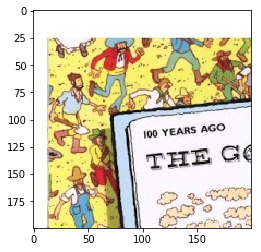

In [17]:
def svm_probability(train_image_feats, train_labels, test_image_feats):
    categories = list(set(train_labels))
    test_labels = []
    
    clf = SVC(C=2, gamma='scale',probability=True)
    clf.fit(train_image_feats, train_labels)
    test_probabilities = clf.predict_proba(test_image_feats)

    return test_probabilities

def sliding_window(window_size=20, step_size=0):
    f = open('datasets/ImageSets/val.txt')
    wa = open('my_waldo.txt', 'w+')
    we = open('my_wenda.txt', 'w+')
    wi = open('my_wizard.txt', 'w+')
    
    image_id = f.readline().rstrip()
    while image_id:
        image = np.asarray(plt.imread('datasets/JPEGImages/' + image_id + '.jpg'))
        height, width, c = image.shape
        
        test_feats = []
        
        for i in range(0, height-window_size, step_size):
            for j in range(0, width-window_size, step_size):
                img = image[i:i+window_size, j:j+window_size]
                feats = bags_of_sifts(vocab_filename=vocab_filename, img=img)
                test_feats.extend(feats)

        predicted_probabilities = svm_probability(training_feats, train_labels, test_feats)
        locations = np.argmax(predicted_probabilities, axis=0)
        conf = np.max(predicted_probabilities, axis=0)
        
        for k in range(len(locations)):
            i = locations[k] // (height-window_size)
            j = locations[k] % (width-window_size)
            patch = image[i:i+window_size, j:j+window_size]
            plt.imshow(patch, interpolation='nearest')
            plt.show()
            
            res = image_id + ' ' + str(conf[k]) + ' ' + str(i) + ' ' + str(i+window_size) + ' ' + str(j) + ' ' + str(j+window_size) + '\n'
            
            if k == 0:
                wa.write(res)
            if k == 1:
                we.write(res)
            if k == 2:
                wi.write(res)
                
        image_id = f.readline().rstrip()


sliding_window(20)